# Time Series Anomaly Detector

We will use a concept known as Bollinger Bands to discover when behavior changes from what is "expected" or normal. Bollinger Bands is a volatility indicator and commonly used in stock market trading. 

Scenario: Discover anomalies in number of web pages accessed in a day by a user. Is there a bot copying the curriculum? 

We will accomplish this by breaking down to the following tasks:

1. acquire the data
2. prepare the data
3. make the analysis process (which we will discuss later) work over all users. 
4. Turn the analysis process and calculations into a function that can be used to loop through for each user. 
5. Test the function on a single user. 
6. Analyze by looping over all users. 

The analysis process will look like this, for each user: 

1. compute necessary metrics to arrive at the final metric, %b (percent-b).
2. add user id to the dataframe that contains all the metrics, including %b. 
3. filter to rows where %b indicates anomaly (i.e. > 1)
4. append rows of anomalies of new user to previous users' anomalous activity. 

Finally, we will do a quick sample of exploration of the anomalies. There is much more you can do! 

Your exercise will be to add comments, markdown, and docstrings to the code in this lesson. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# from matplotlib import style
import seaborn as sns
%matplotlib inline

# pd.plotting.register_matplotlib_converters()


**Acquire**

After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the fields represent. We then parse and name the fields accordingly. 

In [5]:
df = pd.read_csv('cleaned_log.csv')

In [8]:
df.drop(columns='Unnamed: 0', inplace=True)

In [9]:
df

,ip_address,datetime,request_type,day,hour,minute
0,54.36.149.41,2019-01-22 03:56:14,GET,22,3,56
1,31.56.96.51,2019-01-22 03:56:16,GET,22,3,56
2,31.56.96.51,2019-01-22 03:56:16,GET,22,3,56
3,40.77.167.129,2019-01-22 03:56:17,GET,22,3,56
4,91.99.72.15,2019-01-22 03:56:17,GET,22,3,56
...,...,...,...,...,...,...
10365093,188.229.21.56,2019-01-26 20:29:13,GET,26,20,29
10365094,5.127.220.71,2019-01-26 20:29:13,GET,26,20,29
10365095,5.213.7.50,2019-01-26 20:29:13,GET,26,20,29
10365096,109.125.169.52,2019-01-26 20:29:13,GET,26,20,29


**Prepare**


In [39]:
df.datetime = pd.to_datetime(df.datetime)
df = df.set_index(df.datetime)
hits = df['request_type'].resample('h').count()
hits.head()

datetime
2019-01-22 03:00:00     1285
2019-01-22 04:00:00    14471
2019-01-22 05:00:00    14867
2019-01-22 06:00:00    19357
2019-01-22 07:00:00    47800
Freq: H, Name: request_type, dtype: int64

In [40]:
df.head()

,ip_address,datetime,request_type,day,hour,minute
datetime,,,,,,
2019-01-22 03:56:14,54.36.149.41,2019-01-22 03:56:14,GET,22,3,56
2019-01-22 03:56:16,31.56.96.51,2019-01-22 03:56:16,GET,22,3,56
2019-01-22 03:56:16,31.56.96.51,2019-01-22 03:56:16,GET,22,3,56
2019-01-22 03:56:17,40.77.167.129,2019-01-22 03:56:17,GET,22,3,56
2019-01-22 03:56:17,91.99.72.15,2019-01-22 03:56:17,GET,22,3,56


<AxesSubplot:xlabel='datetime'>

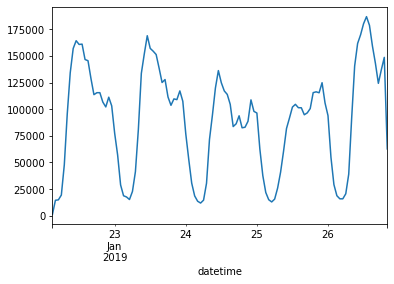

In [41]:
hits.plot()

No need to split because we are not modeling, we are using statistics to identify low probability cases. 

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this: 

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where: 

- M = Number of time periods, span of the window

- $t_{0}$ = Latest value

- $t-1$ = Previous value

- $EMA_{t-1}$ = Exponential moving average of previous day. 

- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. 
So we just need to define the following: 

- M = `span` argument = number of time periods. We will try 7 days, 14 days, and 30 days. 

- Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value. 

In [42]:
# 7 hour EMA
ema_7d = hits.ewm(span=7).mean()
ema_7d.head()

datetime
2019-01-22 03:00:00     1285.000000
2019-01-22 04:00:00     8819.857143
2019-01-22 05:00:00    11434.837838
2019-01-22 06:00:00    14332.085714
2019-01-22 07:00:00    25302.362356
Freq: H, Name: request_type, dtype: float64

In [43]:
# 14 days EMA
ema_14d = hits.ewm(span=14).mean()
ema_14d.head()

datetime
2019-01-22 03:00:00     1285.000000
2019-01-22 04:00:00     8348.928571
2019-01-22 05:00:00    10838.853990
2019-01-22 06:00:00    13444.795141
2019-01-22 07:00:00    22408.015522
Freq: H, Name: request_type, dtype: float64

In [44]:
# 30 days EMA
ema_30d = hits.ewm(span=30).mean()
ema_30d.head()

datetime
2019-01-22 03:00:00     1285.000000
2019-01-22 04:00:00     8097.766667
2019-01-22 05:00:00    10506.220289
2019-01-22 06:00:00    12944.932630
2019-01-22 07:00:00    20875.304333
Freq: H, Name: request_type, dtype: float64

In [45]:
# 90 days EMA
ema_90d = hits.ewm(span=90).mean()
ema_90d.head()

datetime
2019-01-22 03:00:00     1285.000000
2019-01-22 04:00:00     7951.255556
2019-01-22 05:00:00    10307.919057
2019-01-22 06:00:00    12646.150611
2019-01-22 07:00:00    19992.831795
Freq: H, Name: request_type, dtype: float64

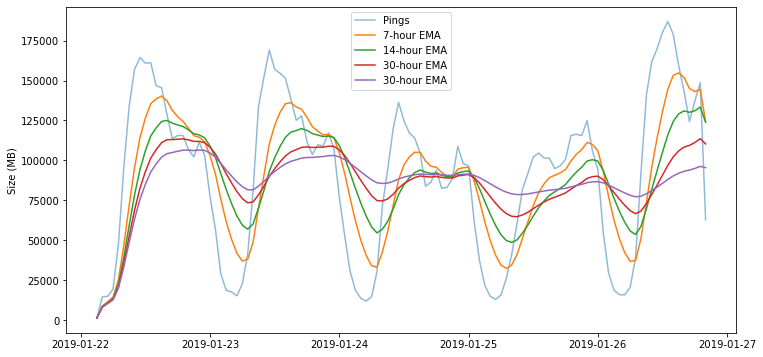

In [46]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(hits.index, hits, label='Pings', alpha=.5)

ax.plot(hits.index, ema_7d, label = '7-hour EMA')
ax.plot(hits.index, ema_14d, label = '14-hour EMA')
ax.plot(hits.index, ema_30d, label = '30-hour EMA')
ax.plot(hits.index, ema_90d, label = '30-hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=30).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=30).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$


In [47]:
# set the window span
span = 30

# compute midband
midband = hits.ewm(span=span).mean()

midband.head()

datetime
2019-01-22 03:00:00     1285.000000
2019-01-22 04:00:00     8097.766667
2019-01-22 05:00:00    10506.220289
2019-01-22 06:00:00    12944.932630
2019-01-22 07:00:00    20875.304333
Freq: H, Name: request_type, dtype: float64

In [48]:
# compute exponential stdev
stdev = hits.ewm(span=span).std()

stdev.head()

datetime
2019-01-22 03:00:00             NaN
2019-01-22 04:00:00     9323.910017
2019-01-22 05:00:00     7602.380961
2019-01-22 06:00:00     7623.705075
2019-01-22 07:00:00    17595.554263
Freq: H, Name: request_type, dtype: float64

In [49]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub

datetime
2019-01-22 03:00:00              NaN
2019-01-22 04:00:00     36069.496717
2019-01-22 05:00:00     33313.363172
2019-01-22 06:00:00     35816.047855
2019-01-22 07:00:00     73661.967124
                           ...      
2019-01-26 16:00:00    283793.030931
2019-01-26 17:00:00    279491.739039
2019-01-26 18:00:00    277004.585833
2019-01-26 19:00:00    276442.638092
2019-01-26 20:00:00    272370.177122
Freq: H, Name: request_type, Length: 114, dtype: float64

In [50]:
lb

datetime
2019-01-22 03:00:00             NaN
2019-01-22 04:00:00   -19873.963384
2019-01-22 05:00:00   -12300.922594
2019-01-22 06:00:00    -9926.182594
2019-01-22 07:00:00   -31911.358457
                           ...     
2019-01-26 16:00:00   -67083.326126
2019-01-26 17:00:00   -60716.627128
2019-01-26 18:00:00   -54652.409059
2019-01-26 19:00:00   -49240.530637
2019-01-26 20:00:00   -51737.290413
Freq: H, Name: request_type, Length: 114, dtype: float64

In [51]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
datetime,,
2019-01-22 03:00:00,NaN,NaN
2019-01-22 04:00:00,36069.496717,-19873.963384
2019-01-22 05:00:00,33313.363172,-12300.922594
2019-01-22 06:00:00,35816.047855,-9926.182594
2019-01-22 07:00:00,73661.967124,-31911.358457


In [52]:
my_df = pd.concat([hits, midband, bb], axis=1)
my_df.columns = ['hits', 'midband', 'ub', 'lb']
my_df.head()

,hits,midband,ub,lb
datetime,,,,
2019-01-22 03:00:00,1285,1285.000000,NaN,NaN
2019-01-22 04:00:00,14471,8097.766667,36069.496717,-19873.963384
2019-01-22 05:00:00,14867,10506.220289,33313.363172,-12300.922594
2019-01-22 06:00:00,19357,12944.932630,35816.047855,-9926.182594
2019-01-22 07:00:00,47800,20875.304333,73661.967124,-31911.358457


Plot the bands

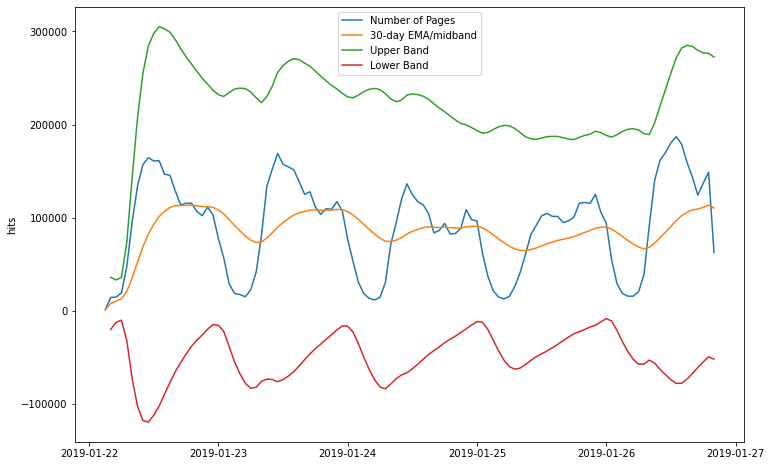

In [53]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.hits, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('hits')

plt.show()

Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

Each row/time period, will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b: 

In [31]:
# get the last measure of gb
last_measure = my_df.iloc[-1].hits

In [32]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb

-51737.29041286727

In [33]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub

272370.17712229746

In [34]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.35


In [35]:
my_df.tail(3)

,hits,midband,ub,lb
datetime,,,,
2019-01-26 18:00:00,137094,111176.088387,277004.585833,-54652.409059
2019-01-26 19:00:00,148743,113601.053727,276442.638092,-49240.530637
2019-01-26 20:00:00,62715,110316.443355,272370.177122,-51737.290413


So, to compute for each point in time: 

In [37]:
my_df['pct_b'] = (my_df['hits'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,hits,midband,ub,lb,pct_b
datetime,,,,,
2019-01-22 03:00:00,1285,1285.000000,NaN,NaN,NaN
2019-01-22 04:00:00,14471,8097.766667,36069.496717,-19873.963384,0.613923
2019-01-22 05:00:00,14867,10506.220289,33313.363172,-12300.922594,0.595601
2019-01-22 06:00:00,19357,12944.932630,35816.047855,-9926.182594,0.640178
2019-01-22 07:00:00,47800,20875.304333,73661.967124,-31911.358457,0.755033


Now, where do we see anomalies? We will search for %b values > 1. We don't need to search for values < 0 because with this example, a low extreme is not something we are concerned about. 

In [38]:
my_df[my_df['pct_b']>1]

,hits,midband,ub,lb,pct_b
datetime,,,,,


## Pull it all together!

1. acquire
2. prep with user
3. compute features
    - compute midband
    - compute standard deviation
    - compute upper & lower band
    - create df with metrics
    - compute %b
    - add user_id to dataframe
4. Plot
5. search for anomalies

In [71]:
def acquire(file_name, column_names):
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]

Acquire

In [72]:
file_name = "anonymized-curriculum-access.txt"
column_names = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = acquire(file_name, column_names)
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


Test on a single user

In [73]:
user = 1
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

Loop through all users 

In [74]:
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

Explore anomalies

In [75]:
anomalies.pages.value_counts(sort=False)

1      48
2      36
3      71
4      76
5      58
       ..
165     1
179     1
192     1
198     1
272     1
Name: pages, Length: 99, dtype: int64

In [76]:
anomalies[anomalies.pages==272]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341


hmmmmmmmmmmm.......

In [77]:
anomalies[anomalies.user_id==341]

,pages,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2020-02-18,3,0.193548,2.817185,-2.430088,1.034840,341
2020-04-21,109,7.250725,102.413277,-87.911826,1.034608,341
2021-02-09,10,0.659630,9.508602,-8.189342,1.027766,341


In [78]:
df[df.user_id==341]

,date,endpoint,user_id,cohort_id,source_ip
181808,2019-01-22,/,341,29.0,97.105.19.58
181826,2019-01-22,toc,341,29.0,97.105.19.58
181840,2019-01-22,html-css,341,29.0,97.105.19.58
181862,2019-01-22,html-css/introduction,341,29.0,97.105.19.58
181870,2019-01-22,html-css/elements,341,29.0,97.105.19.58
...,...,...,...,...,...
817183,2021-02-09,search/search_index.json,341,29.0,172.124.70.146
817184,2021-02-09,appendix/further-reading/spring/seeder,341,29.0,172.124.70.146
817268,2021-02-10,appendix/code-standards/mysql,341,29.0,172.124.70.146
817269,2021-02-10,appendix/further-reading/spring/pagination,341,29.0,172.124.70.146


This is worth investigating! 

## Exercises

**file name:** time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is `curriculum_logs`.

Go through the lesson commenting code, adding docstrings, and adding markdown to support what is happening. 

Bonus:

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Can you label students who are viewing both the web dev and data science curriculum?
Can you label students by the program they are in? 
Can you label users by student vs. staff?